In [1]:
from unityagents import UnityEnvironment
import numpy as np

In [2]:
env = UnityEnvironment(file_name="./Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [17]:
%load_ext autoreload
%autoreload 2
from model import Agent
from tqdm import tqdm
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
BATCH_SIZE = 16         # Batch size of training samples.
EMBED_DIM = 256         # Embed size of the agent.
NUM_EPISODES = 2500     # Maximum training episodes.
LOG_INTERVAL = 128      # The interval to print the average scores
LEARN_NUM = 16          # Learning times at each episode.
BUFFER_SIZE = int(1e6)  # The buffer size of the replay buffer.

agent = Agent(state_size, action_size, buffer_size=BUFFER_SIZE)
best_scores = 0.5
max_scores = []
avg_scores = []

In [21]:
NUM_EPISODES = 3360
with tqdm(total=NUM_EPISODES) as pbar:
    for i_episode in range(NUM_EPISODES):
        pbar.update(1)
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        episodic_observations, episodic_actions, episodic_rewards, episodic_nstates, episodic_dones = [], [], [], [], []
        while True:
            actions = agent.act(states)                        # select an action (for each agent)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = np.array(env_info.rewards)               # get reward (for each agent)
            dones = np.array(env_info.local_done)              # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)

            # Save episode
            episodic_observations.append(np.stack([states.reshape(-1), states.reshape(-1)], axis=0))
            episodic_actions.append(np.stack([actions.reshape(-1), actions.reshape(-1)], axis=0))
            episodic_rewards.append(rewards)
            episodic_nstates.append(np.stack([next_states.reshape(-1), next_states.reshape(-1)], axis=0))
            episodic_dones.append(dones)
            
            states = next_states
            if np.any(dones):                                  # exit loop if episode finished
                break
                
        episodic_observations = np.stack(episodic_observations, 1)  # [2, seq_len, states_size]
        episodic_actions = np.stack(episodic_actions, 1)
        episodic_rewards = np.stack(episodic_rewards, 1)
        episodic_nstates = np.stack(episodic_nstates, 1)
        episodic_dones = np.stack(episodic_dones, 1)

        for j in range(num_agents):
            if j == 0:
                agent.memory_0.add(episodic_observations[j], episodic_actions[j], episodic_rewards[j], episodic_nstates[j], episodic_dones[j])
            if j == 1:
                agent.memory_1.add(episodic_observations[j], episodic_actions[j], episodic_rewards[j], episodic_nstates[j], episodic_dones[j])

        if i_episode > 2*BATCH_SIZE:
            agent.step(BATCH_SIZE, learn_num=LEARN_NUM)
            max_scores.append(np.max(scores))
            avg_score = np.mean(max_scores[-100:])
            avg_scores.append(avg_score)
            if i_episode % LOG_INTERVAL == 0:
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, avg_score))
            if avg_score > best_scores:
                best_scores = avg_score
                best_scores = max_scores[-1]
                torch.save({'agent': agent.state_dict()}, 'MADDPG.ckpt')
                print('Save model successful.')

  2%|▏         | 66/3360 [00:15<23:39,  2.32it/s]

q_value: 0.05567, critic_loss: 0.00006, actor_loss: -0.02189 
q_value: 0.02168, critic_loss: 0.00000, actor_loss: 0.00562 
q_value: 0.06473, critic_loss: 0.00009, actor_loss: -0.04705 
q_value: 0.01539, critic_loss: 0.00000, actor_loss: 0.00636 
q_value: 0.05922, critic_loss: 0.00004, actor_loss: -0.03680 
q_value: 0.02666, critic_loss: 0.00001, actor_loss: 0.00521 
q_value: 0.05790, critic_loss: 0.00006, actor_loss: -0.03073 
q_value: 0.02057, critic_loss: 0.00006, actor_loss: 0.00262 
q_value: 0.05745, critic_loss: 0.00004, actor_loss: -0.02777 
q_value: 0.03192, critic_loss: 0.00001, actor_loss: 0.00593 
q_value: 0.07024, critic_loss: 0.00008, actor_loss: -0.02965 
q_value: 0.03027, critic_loss: 0.00001, actor_loss: 0.00249 
q_value: 0.05931, critic_loss: 0.00008, actor_loss: -0.03349 
q_value: 0.02977, critic_loss: 0.00001, actor_loss: 0.00351 
q_value: 0.06574, critic_loss: 0.00006, actor_loss: -0.04921 
q_value: 0.02432, critic_loss: 0.00000, actor_loss: 0.00581 
q_value: 0.06634

  2%|▏         | 67/3360 [00:15<23:20,  2.35it/s]

q_value: 0.02518, critic_loss: 0.00001, actor_loss: 0.00678 
q_value: 0.06437, critic_loss: 0.00008, actor_loss: -0.04300 
q_value: 0.03345, critic_loss: 0.00004, actor_loss: 0.00668 
q_value: 0.06717, critic_loss: 0.00008, actor_loss: -0.02732 
q_value: 0.03301, critic_loss: 0.00001, actor_loss: 0.00305 
q_value: 0.06791, critic_loss: 0.00008, actor_loss: -0.03483 
q_value: 0.02542, critic_loss: 0.00002, actor_loss: 0.00356 
q_value: 0.07142, critic_loss: 0.00007, actor_loss: -0.03212 
q_value: 0.02373, critic_loss: 0.00000, actor_loss: 0.00606 
q_value: 0.06711, critic_loss: 0.00006, actor_loss: -0.02701 
q_value: 0.03613, critic_loss: 0.00002, actor_loss: 0.00436 
q_value: 0.05616, critic_loss: 0.00003, actor_loss: -0.02960 
q_value: 0.02010, critic_loss: 0.00000, actor_loss: 0.00574 


  4%|▍         | 130/3360 [00:41<22:15,  2.42it/s]

Episode 128	Average Score: 0.03


  6%|▌         | 194/3360 [01:08<22:31,  2.34it/s]

q_value: 0.05802, critic_loss: 0.00006, actor_loss: -0.03166 
q_value: 0.01949, critic_loss: 0.00003, actor_loss: -0.00262 
q_value: 0.06439, critic_loss: 0.00005, actor_loss: -0.02263 
q_value: 0.01074, critic_loss: 0.00001, actor_loss: 0.00259 
q_value: 0.06790, critic_loss: 0.00005, actor_loss: -0.01985 
q_value: 0.01420, critic_loss: 0.00000, actor_loss: 0.00199 
q_value: 0.06597, critic_loss: 0.00010, actor_loss: -0.03317 
q_value: 0.01595, critic_loss: 0.00001, actor_loss: 0.00112 
q_value: 0.06345, critic_loss: 0.00007, actor_loss: -0.04284 
q_value: 0.01432, critic_loss: 0.00002, actor_loss: 0.00191 
q_value: 0.05535, critic_loss: 0.00002, actor_loss: -0.02553 
q_value: 0.01123, critic_loss: 0.00001, actor_loss: 0.00339 
q_value: 0.07246, critic_loss: 0.00006, actor_loss: -0.03785 
q_value: 0.00896, critic_loss: 0.00001, actor_loss: 0.00436 
q_value: 0.06563, critic_loss: 0.00006, actor_loss: -0.03413 
q_value: 0.02042, critic_loss: 0.00002, actor_loss: 0.00102 
q_value: 0.0697

  6%|▌         | 195/3360 [01:08<22:26,  2.35it/s]

q_value: 0.01221, critic_loss: 0.00002, actor_loss: 0.00104 
q_value: 0.06121, critic_loss: 0.00003, actor_loss: -0.02318 
q_value: 0.01508, critic_loss: 0.00002, actor_loss: 0.00195 
q_value: 0.06982, critic_loss: 0.00007, actor_loss: -0.03562 
q_value: 0.00100, critic_loss: 0.00000, actor_loss: 0.00334 
q_value: 0.06422, critic_loss: 0.00007, actor_loss: -0.01902 
q_value: 0.01481, critic_loss: 0.00002, actor_loss: 0.00052 
q_value: 0.06613, critic_loss: 0.00004, actor_loss: -0.02821 
q_value: 0.01608, critic_loss: 0.00002, actor_loss: 0.00136 
q_value: 0.05410, critic_loss: 0.00005, actor_loss: -0.02426 
q_value: 0.01431, critic_loss: 0.00001, actor_loss: 0.00097 
q_value: 0.05505, critic_loss: 0.00002, actor_loss: -0.01400 
q_value: 0.01321, critic_loss: 0.00002, actor_loss: -0.00097 
q_value: 0.07128, critic_loss: 0.00004, actor_loss: -0.01626 
q_value: 0.01541, critic_loss: 0.00001, actor_loss: 0.00218 


  8%|▊         | 258/3360 [01:34<21:21,  2.42it/s]

Episode 256	Average Score: 0.02


 10%|▉         | 322/3360 [02:01<20:25,  2.48it/s]

q_value: 0.05542, critic_loss: 0.00004, actor_loss: -0.01760 
q_value: 0.00553, critic_loss: 0.00001, actor_loss: 0.00379 
q_value: 0.05473, critic_loss: 0.00005, actor_loss: -0.01587 
q_value: 0.01046, critic_loss: 0.00003, actor_loss: -0.00178 
q_value: 0.05708, critic_loss: 0.00004, actor_loss: -0.02671 
q_value: 0.00889, critic_loss: 0.00002, actor_loss: 0.00223 
q_value: 0.06780, critic_loss: 0.00004, actor_loss: -0.02536 
q_value: 0.00845, critic_loss: 0.00003, actor_loss: -0.00022 
q_value: 0.05943, critic_loss: 0.00005, actor_loss: -0.02816 
q_value: 0.01112, critic_loss: 0.00002, actor_loss: 0.00039 
q_value: 0.07198, critic_loss: 0.00004, actor_loss: -0.05127 
q_value: 0.00880, critic_loss: 0.00003, actor_loss: 0.00248 
q_value: 0.05568, critic_loss: 0.00006, actor_loss: -0.02292 
q_value: 0.01009, critic_loss: 0.00002, actor_loss: -0.00005 
q_value: 0.06213, critic_loss: 0.00003, actor_loss: -0.01617 
q_value: 0.01197, critic_loss: 0.00001, actor_loss: -0.00008 
q_value: 0.0

 10%|▉         | 323/3360 [02:01<20:09,  2.51it/s]

q_value: 0.01030, critic_loss: 0.00002, actor_loss: 0.00025 
q_value: 0.03999, critic_loss: 0.00005, actor_loss: -0.03828 
q_value: 0.01305, critic_loss: 0.00002, actor_loss: 0.00100 
q_value: 0.05976, critic_loss: 0.00004, actor_loss: -0.02405 
q_value: 0.01508, critic_loss: 0.00003, actor_loss: 0.00209 
q_value: 0.06547, critic_loss: 0.00006, actor_loss: -0.03720 
q_value: 0.01180, critic_loss: 0.00001, actor_loss: -0.00014 
q_value: 0.05589, critic_loss: 0.00007, actor_loss: -0.02147 
q_value: 0.00644, critic_loss: 0.00001, actor_loss: 0.00524 
q_value: 0.06631, critic_loss: 0.00006, actor_loss: -0.03409 
q_value: 0.01154, critic_loss: 0.00002, actor_loss: -0.00414 
q_value: 0.06904, critic_loss: 0.00008, actor_loss: -0.02755 
q_value: 0.00937, critic_loss: 0.00001, actor_loss: 0.00039 


 11%|█▏        | 386/3360 [02:27<20:15,  2.45it/s]

Episode 384	Average Score: 0.03


 13%|█▎        | 450/3360 [02:55<20:50,  2.33it/s]

q_value: 0.06570, critic_loss: 0.00002, actor_loss: -0.02497 
q_value: 0.03579, critic_loss: 0.00004, actor_loss: -0.02526 
q_value: 0.07249, critic_loss: 0.00005, actor_loss: -0.04658 
q_value: 0.02924, critic_loss: 0.00002, actor_loss: -0.01504 
q_value: 0.08258, critic_loss: 0.00005, actor_loss: -0.03522 
q_value: 0.02570, critic_loss: 0.00002, actor_loss: -0.00919 
q_value: 0.06916, critic_loss: 0.00006, actor_loss: -0.03825 
q_value: 0.03376, critic_loss: 0.00002, actor_loss: -0.01189 
q_value: 0.06857, critic_loss: 0.00003, actor_loss: -0.03707 
q_value: 0.03496, critic_loss: 0.00002, actor_loss: -0.01729 
q_value: 0.07829, critic_loss: 0.00003, actor_loss: -0.02773 
q_value: 0.03101, critic_loss: 0.00003, actor_loss: -0.00884 
q_value: 0.07209, critic_loss: 0.00009, actor_loss: -0.03902 
q_value: 0.03129, critic_loss: 0.00002, actor_loss: -0.01488 
q_value: 0.06508, critic_loss: 0.00001, actor_loss: -0.02523 
q_value: 0.02881, critic_loss: 0.00003, actor_loss: -0.01637 
q_value:

 13%|█▎        | 451/3360 [02:55<21:15,  2.28it/s]

q_value: 0.03344, critic_loss: 0.00004, actor_loss: -0.01585 
q_value: 0.06219, critic_loss: 0.00003, actor_loss: -0.02737 
q_value: 0.02679, critic_loss: 0.00002, actor_loss: -0.00907 
q_value: 0.06382, critic_loss: 0.00006, actor_loss: -0.04008 
q_value: 0.03269, critic_loss: 0.00002, actor_loss: -0.01624 
q_value: 0.07126, critic_loss: 0.00004, actor_loss: -0.02586 
q_value: 0.02626, critic_loss: 0.00002, actor_loss: -0.01069 
q_value: 0.08265, critic_loss: 0.00005, actor_loss: -0.04867 
q_value: 0.03430, critic_loss: 0.00004, actor_loss: -0.01578 
q_value: 0.07473, critic_loss: 0.00006, actor_loss: -0.02228 
q_value: 0.03747, critic_loss: 0.00005, actor_loss: -0.01432 
q_value: 0.06711, critic_loss: 0.00003, actor_loss: -0.03431 
q_value: 0.03174, critic_loss: 0.00002, actor_loss: -0.01059 


 15%|█▌        | 514/3360 [03:23<19:45,  2.40it/s]

Episode 512	Average Score: 0.05


 17%|█▋        | 578/3360 [03:52<20:54,  2.22it/s]

q_value: 0.07131, critic_loss: 0.00004, actor_loss: -0.02945 
q_value: 0.04231, critic_loss: 0.00008, actor_loss: -0.04156 
q_value: 0.08464, critic_loss: 0.00007, actor_loss: -0.04430 
q_value: 0.04683, critic_loss: 0.00008, actor_loss: -0.04828 
q_value: 0.08301, critic_loss: 0.00004, actor_loss: -0.05045 
q_value: 0.03609, critic_loss: 0.00006, actor_loss: -0.03021 
q_value: 0.07876, critic_loss: 0.00004, actor_loss: -0.04314 
q_value: 0.03107, critic_loss: 0.00003, actor_loss: -0.02097 
q_value: 0.07724, critic_loss: 0.00006, actor_loss: -0.03826 
q_value: 0.03737, critic_loss: 0.00005, actor_loss: -0.02974 
q_value: 0.06685, critic_loss: 0.00003, actor_loss: -0.02601 
q_value: 0.03961, critic_loss: 0.00005, actor_loss: -0.02476 
q_value: 0.07362, critic_loss: 0.00004, actor_loss: -0.02868 
q_value: 0.02352, critic_loss: 0.00004, actor_loss: -0.01448 
q_value: 0.06212, critic_loss: 0.00006, actor_loss: -0.03125 
q_value: 0.04219, critic_loss: 0.00007, actor_loss: -0.03475 
q_value:

 17%|█▋        | 579/3360 [03:52<20:34,  2.25it/s]

q_value: 0.04499, critic_loss: 0.00006, actor_loss: -0.04652 
q_value: 0.05915, critic_loss: 0.00004, actor_loss: -0.02296 
q_value: 0.03855, critic_loss: 0.00006, actor_loss: -0.03723 
q_value: 0.08033, critic_loss: 0.00006, actor_loss: -0.02549 
q_value: 0.04119, critic_loss: 0.00007, actor_loss: -0.03048 
q_value: 0.08219, critic_loss: 0.00006, actor_loss: -0.03442 
q_value: 0.03613, critic_loss: 0.00004, actor_loss: -0.03220 
q_value: 0.08467, critic_loss: 0.00005, actor_loss: -0.06294 
q_value: 0.03630, critic_loss: 0.00006, actor_loss: -0.02643 
q_value: 0.06299, critic_loss: 0.00004, actor_loss: -0.02454 
q_value: 0.03964, critic_loss: 0.00006, actor_loss: -0.03790 
q_value: 0.06675, critic_loss: 0.00002, actor_loss: -0.00989 
q_value: 0.03908, critic_loss: 0.00004, actor_loss: -0.02409 
q_value: 0.07161, critic_loss: 0.00005, actor_loss: -0.02436 
q_value: 0.04635, critic_loss: 0.00007, actor_loss: -0.04980 


 19%|█▉        | 642/3360 [04:21<20:31,  2.21it/s]

Episode 640	Average Score: 0.07


 21%|██        | 706/3360 [04:50<20:01,  2.21it/s]

q_value: 0.06932, critic_loss: 0.00010, actor_loss: -0.03142 
q_value: 0.04593, critic_loss: 0.00007, actor_loss: -0.02202 
q_value: 0.07514, critic_loss: 0.00008, actor_loss: -0.04133 
q_value: 0.05135, critic_loss: 0.00007, actor_loss: -0.04650 
q_value: 0.05141, critic_loss: 0.00001, actor_loss: -0.01335 
q_value: 0.04444, critic_loss: 0.00007, actor_loss: -0.03222 
q_value: 0.07575, critic_loss: 0.00007, actor_loss: -0.04483 
q_value: 0.04527, critic_loss: 0.00005, actor_loss: -0.03486 
q_value: 0.06872, critic_loss: 0.00006, actor_loss: -0.04254 
q_value: 0.04863, critic_loss: 0.00006, actor_loss: -0.03369 
q_value: 0.05873, critic_loss: 0.00005, actor_loss: -0.03475 
q_value: 0.04256, critic_loss: 0.00006, actor_loss: -0.02124 
q_value: 0.05696, critic_loss: 0.00006, actor_loss: -0.03301 
q_value: 0.04810, critic_loss: 0.00005, actor_loss: -0.03741 
q_value: 0.06114, critic_loss: 0.00003, actor_loss: -0.03043 
q_value: 0.05340, critic_loss: 0.00005, actor_loss: -0.03826 


 21%|██        | 707/3360 [04:50<20:37,  2.14it/s]

q_value: 0.06077, critic_loss: 0.00007, actor_loss: -0.03593 
q_value: 0.04907, critic_loss: 0.00005, actor_loss: -0.03338 
q_value: 0.07279, critic_loss: 0.00003, actor_loss: -0.03764 
q_value: 0.04880, critic_loss: 0.00007, actor_loss: -0.03464 
q_value: 0.07371, critic_loss: 0.00005, actor_loss: -0.04164 
q_value: 0.05224, critic_loss: 0.00010, actor_loss: -0.04187 
q_value: 0.06963, critic_loss: 0.00005, actor_loss: -0.03573 
q_value: 0.04944, critic_loss: 0.00008, actor_loss: -0.02849 
q_value: 0.06968, critic_loss: 0.00005, actor_loss: -0.04228 
q_value: 0.04200, critic_loss: 0.00006, actor_loss: -0.03252 
q_value: 0.06682, critic_loss: 0.00007, actor_loss: -0.03602 
q_value: 0.04899, critic_loss: 0.00008, actor_loss: -0.02685 
q_value: 0.06674, critic_loss: 0.00004, actor_loss: -0.02997 
q_value: 0.04750, critic_loss: 0.00009, actor_loss: -0.02442 
q_value: 0.06943, critic_loss: 0.00006, actor_loss: -0.04397 
q_value: 0.04401, critic_loss: 0.00004, actor_loss: -0.02441 


 23%|██▎       | 770/3360 [05:20<20:04,  2.15it/s]

Episode 768	Average Score: 0.07


 25%|██▍       | 834/3360 [05:52<23:07,  1.82it/s]

q_value: 0.06878, critic_loss: 0.00005, actor_loss: -0.03214 
q_value: 0.05646, critic_loss: 0.00009, actor_loss: -0.04616 
q_value: 0.05873, critic_loss: 0.00005, actor_loss: -0.04094 
q_value: 0.05518, critic_loss: 0.00011, actor_loss: -0.04804 
q_value: 0.05802, critic_loss: 0.00003, actor_loss: -0.03437 
q_value: 0.05713, critic_loss: 0.00009, actor_loss: -0.05116 
q_value: 0.06577, critic_loss: 0.00006, actor_loss: -0.03754 
q_value: 0.05336, critic_loss: 0.00010, actor_loss: -0.03669 
q_value: 0.06281, critic_loss: 0.00007, actor_loss: -0.02879 
q_value: 0.05680, critic_loss: 0.00017, actor_loss: -0.04574 
q_value: 0.06032, critic_loss: 0.00003, actor_loss: -0.03196 
q_value: 0.05184, critic_loss: 0.00006, actor_loss: -0.03684 
q_value: 0.06876, critic_loss: 0.00005, actor_loss: -0.03247 
q_value: 0.06225, critic_loss: 0.00014, actor_loss: -0.06292 
q_value: 0.05575, critic_loss: 0.00005, actor_loss: -0.03342 
q_value: 0.05868, critic_loss: 0.00015, actor_loss: -0.05776 


 25%|██▍       | 835/3360 [05:53<22:00,  1.91it/s]

q_value: 0.07076, critic_loss: 0.00007, actor_loss: -0.03281 
q_value: 0.05375, critic_loss: 0.00009, actor_loss: -0.04677 
q_value: 0.06800, critic_loss: 0.00005, actor_loss: -0.02685 
q_value: 0.05226, critic_loss: 0.00009, actor_loss: -0.04505 
q_value: 0.06117, critic_loss: 0.00003, actor_loss: -0.02817 
q_value: 0.05442, critic_loss: 0.00012, actor_loss: -0.04028 
q_value: 0.07679, critic_loss: 0.00006, actor_loss: -0.03519 
q_value: 0.05040, critic_loss: 0.00008, actor_loss: -0.04130 
q_value: 0.05842, critic_loss: 0.00003, actor_loss: -0.03431 
q_value: 0.06188, critic_loss: 0.00012, actor_loss: -0.05224 
q_value: 0.06100, critic_loss: 0.00006, actor_loss: -0.03999 
q_value: 0.05051, critic_loss: 0.00006, actor_loss: -0.03855 
q_value: 0.06806, critic_loss: 0.00005, actor_loss: -0.03888 
q_value: 0.05792, critic_loss: 0.00009, actor_loss: -0.05650 
q_value: 0.05768, critic_loss: 0.00003, actor_loss: -0.03542 
q_value: 0.05518, critic_loss: 0.00007, actor_loss: -0.04928 


 27%|██▋       | 898/3360 [06:26<21:20,  1.92it/s]

Episode 896	Average Score: 0.10


 29%|██▊       | 962/3360 [07:02<22:01,  1.82it/s]

q_value: 0.08308, critic_loss: 0.00004, actor_loss: -0.01682 
q_value: 0.04921, critic_loss: 0.00006, actor_loss: -0.05790 
q_value: 0.05599, critic_loss: 0.00003, actor_loss: -0.02981 
q_value: 0.04974, critic_loss: 0.00009, actor_loss: -0.04992 
q_value: 0.05962, critic_loss: 0.00002, actor_loss: -0.02298 
q_value: 0.04384, critic_loss: 0.00010, actor_loss: -0.03798 
q_value: 0.07377, critic_loss: 0.00004, actor_loss: -0.02725 
q_value: 0.05051, critic_loss: 0.00008, actor_loss: -0.05541 
q_value: 0.07748, critic_loss: 0.00006, actor_loss: -0.04186 
q_value: 0.04976, critic_loss: 0.00008, actor_loss: -0.05898 
q_value: 0.07797, critic_loss: 0.00003, actor_loss: -0.03951 
q_value: 0.04957, critic_loss: 0.00006, actor_loss: -0.05553 
q_value: 0.07692, critic_loss: 0.00005, actor_loss: -0.04075 
q_value: 0.05193, critic_loss: 0.00006, actor_loss: -0.05869 
q_value: 0.06798, critic_loss: 0.00003, actor_loss: -0.03723 
q_value: 0.05165, critic_loss: 0.00008, actor_loss: -0.05660 
q_value:

 29%|██▊       | 963/3360 [07:03<21:43,  1.84it/s]

q_value: 0.04507, critic_loss: 0.00006, actor_loss: -0.04646 


 31%|███       | 1026/3360 [07:38<20:38,  1.89it/s]

Episode 1024	Average Score: 0.11


 31%|███       | 1045/3360 [07:48<27:15,  1.42it/s]

Save model successful.


 32%|███▏      | 1090/3360 [08:16<26:09,  1.45it/s]

q_value: 0.08047, critic_loss: 0.00003, actor_loss: -0.03290 
q_value: 0.04711, critic_loss: 0.00010, actor_loss: -0.04510 
q_value: 0.06470, critic_loss: 0.00003, actor_loss: -0.03454 
q_value: 0.03994, critic_loss: 0.00008, actor_loss: -0.03418 
q_value: 0.08239, critic_loss: 0.00003, actor_loss: -0.02619 
q_value: 0.04285, critic_loss: 0.00003, actor_loss: -0.03680 
q_value: 0.05910, critic_loss: 0.00005, actor_loss: -0.03302 
q_value: 0.04835, critic_loss: 0.00007, actor_loss: -0.05052 
q_value: 0.08942, critic_loss: 0.00004, actor_loss: -0.03998 
q_value: 0.04480, critic_loss: 0.00007, actor_loss: -0.04031 
q_value: 0.07476, critic_loss: 0.00005, actor_loss: -0.03617 
q_value: 0.04578, critic_loss: 0.00006, actor_loss: -0.04576 
q_value: 0.07110, critic_loss: 0.00004, actor_loss: -0.03678 
q_value: 0.04326, critic_loss: 0.00005, actor_loss: -0.03423 
q_value: 0.08211, critic_loss: 0.00005, actor_loss: -0.03003 
q_value: 0.04641, critic_loss: 0.00009, actor_loss: -0.04999 
q_value:

 32%|███▏      | 1091/3360 [08:16<25:52,  1.46it/s]

q_value: 0.07304, critic_loss: 0.00004, actor_loss: -0.02733 
q_value: 0.04082, critic_loss: 0.00006, actor_loss: -0.03471 


 34%|███▍      | 1154/3360 [08:57<19:35,  1.88it/s]

Episode 1152	Average Score: 0.15


 36%|███▌      | 1195/3360 [09:24<34:39,  1.04it/s]

Save model successful.


 36%|███▋      | 1218/3360 [09:41<25:16,  1.41it/s]

q_value: 0.07943, critic_loss: 0.00007, actor_loss: -0.04224 
q_value: 0.04757, critic_loss: 0.00007, actor_loss: -0.04369 
q_value: 0.06947, critic_loss: 0.00004, actor_loss: -0.03356 
q_value: 0.04158, critic_loss: 0.00005, actor_loss: -0.03237 
q_value: 0.07124, critic_loss: 0.00004, actor_loss: -0.01849 
q_value: 0.04741, critic_loss: 0.00005, actor_loss: -0.03332 
q_value: 0.06931, critic_loss: 0.00004, actor_loss: -0.02668 
q_value: 0.05090, critic_loss: 0.00008, actor_loss: -0.04641 
q_value: 0.07236, critic_loss: 0.00003, actor_loss: -0.04125 
q_value: 0.05000, critic_loss: 0.00007, actor_loss: -0.04295 
q_value: 0.06979, critic_loss: 0.00002, actor_loss: -0.03285 
q_value: 0.05248, critic_loss: 0.00006, actor_loss: -0.05155 
q_value: 0.07857, critic_loss: 0.00007, actor_loss: -0.03684 
q_value: 0.05183, critic_loss: 0.00004, actor_loss: -0.03281 
q_value: 0.07749, critic_loss: 0.00006, actor_loss: -0.03789 
q_value: 0.04931, critic_loss: 0.00004, actor_loss: -0.03474 
q_value:

 36%|███▋      | 1219/3360 [09:42<26:27,  1.35it/s]

q_value: 0.08499, critic_loss: 0.00006, actor_loss: -0.03735 
q_value: 0.04651, critic_loss: 0.00003, actor_loss: -0.03537 
q_value: 0.07175, critic_loss: 0.00002, actor_loss: -0.03113 
q_value: 0.04402, critic_loss: 0.00007, actor_loss: -0.04110 
q_value: 0.07487, critic_loss: 0.00005, actor_loss: -0.03357 
q_value: 0.04068, critic_loss: 0.00005, actor_loss: -0.02825 
q_value: 0.05981, critic_loss: 0.00005, actor_loss: -0.03090 
q_value: 0.05048, critic_loss: 0.00010, actor_loss: -0.05211 


 38%|███▊      | 1267/3360 [10:19<46:15,  1.33s/it]

Save model successful.


 38%|███▊      | 1282/3360 [10:33<36:12,  1.05s/it]

Episode 1280	Average Score: 0.21


 40%|████      | 1346/3360 [11:30<31:09,  1.08it/s]

q_value: 0.06521, critic_loss: 0.00004, actor_loss: -0.03655 
q_value: 0.04979, critic_loss: 0.00006, actor_loss: -0.04422 
q_value: 0.07589, critic_loss: 0.00005, actor_loss: -0.03445 
q_value: 0.05103, critic_loss: 0.00008, actor_loss: -0.04565 
q_value: 0.07510, critic_loss: 0.00005, actor_loss: -0.04436 
q_value: 0.05143, critic_loss: 0.00007, actor_loss: -0.04496 
q_value: 0.06758, critic_loss: 0.00003, actor_loss: -0.03511 
q_value: 0.05330, critic_loss: 0.00006, actor_loss: -0.04330 
q_value: 0.06952, critic_loss: 0.00006, actor_loss: -0.03629 
q_value: 0.05018, critic_loss: 0.00006, actor_loss: -0.03751 
q_value: 0.07337, critic_loss: 0.00005, actor_loss: -0.04119 
q_value: 0.04734, critic_loss: 0.00005, actor_loss: -0.04498 
q_value: 0.07369, critic_loss: 0.00006, actor_loss: -0.03441 
q_value: 0.04755, critic_loss: 0.00005, actor_loss: -0.03844 
q_value: 0.07263, critic_loss: 0.00004, actor_loss: -0.03864 
q_value: 0.05089, critic_loss: 0.00005, actor_loss: -0.04308 
q_value:

 40%|████      | 1347/3360 [11:31<31:44,  1.06it/s]

q_value: 0.05075, critic_loss: 0.00005, actor_loss: -0.02642 
q_value: 0.08514, critic_loss: 0.00005, actor_loss: -0.03995 
q_value: 0.05147, critic_loss: 0.00003, actor_loss: -0.04341 
q_value: 0.08038, critic_loss: 0.00003, actor_loss: -0.03541 
q_value: 0.05293, critic_loss: 0.00009, actor_loss: -0.05012 
q_value: 0.07610, critic_loss: 0.00003, actor_loss: -0.03948 
q_value: 0.04678, critic_loss: 0.00003, actor_loss: -0.03674 
q_value: 0.07781, critic_loss: 0.00004, actor_loss: -0.04202 
q_value: 0.05014, critic_loss: 0.00006, actor_loss: -0.04586 


 40%|████      | 1354/3360 [11:40<52:49,  1.58s/it]

Save model successful.


 41%|████▏     | 1387/3360 [12:19<1:02:55,  1.91s/it]

Save model successful.


 42%|████▏     | 1410/3360 [12:46<48:44,  1.50s/it]  

Episode 1408	Average Score: 0.35


 43%|████▎     | 1445/3360 [13:32<1:00:51,  1.91s/it]

Save model successful.


 44%|████▍     | 1474/3360 [14:11<38:54,  1.24s/it]  

q_value: 0.06460, critic_loss: 0.00004, actor_loss: -0.03178 
q_value: 0.05712, critic_loss: 0.00009, actor_loss: -0.04983 
q_value: 0.07076, critic_loss: 0.00008, actor_loss: -0.04124 
q_value: 0.05937, critic_loss: 0.00007, actor_loss: -0.05882 
q_value: 0.05840, critic_loss: 0.00006, actor_loss: -0.02549 
q_value: 0.06058, critic_loss: 0.00007, actor_loss: -0.03904 
q_value: 0.07307, critic_loss: 0.00006, actor_loss: -0.04255 
q_value: 0.05838, critic_loss: 0.00005, actor_loss: -0.04975 
q_value: 0.07273, critic_loss: 0.00007, actor_loss: -0.04979 
q_value: 0.05825, critic_loss: 0.00011, actor_loss: -0.05329 
q_value: 0.07342, critic_loss: 0.00006, actor_loss: -0.04107 
q_value: 0.05862, critic_loss: 0.00008, actor_loss: -0.04520 
q_value: 0.07430, critic_loss: 0.00006, actor_loss: -0.04055 
q_value: 0.05907, critic_loss: 0.00009, actor_loss: -0.05401 
q_value: 0.05385, critic_loss: 0.00005, actor_loss: -0.02936 
q_value: 0.05713, critic_loss: 0.00007, actor_loss: -0.04809 
q_value:

 44%|████▍     | 1475/3360 [14:12<37:00,  1.18s/it]

q_value: 0.07520, critic_loss: 0.00004, actor_loss: -0.04269 
q_value: 0.05652, critic_loss: 0.00005, actor_loss: -0.04020 
q_value: 0.07335, critic_loss: 0.00005, actor_loss: -0.04389 
q_value: 0.05533, critic_loss: 0.00006, actor_loss: -0.04511 
q_value: 0.06489, critic_loss: 0.00006, actor_loss: -0.03561 
q_value: 0.05624, critic_loss: 0.00008, actor_loss: -0.05157 
q_value: 0.07285, critic_loss: 0.00005, actor_loss: -0.04713 
q_value: 0.05633, critic_loss: 0.00012, actor_loss: -0.05603 


 44%|████▍     | 1493/3360 [14:38<1:05:30,  2.11s/it]

Save model successful.


 46%|████▌     | 1538/3360 [16:05<56:52,  1.87s/it]  

Episode 1536	Average Score: 0.63


 48%|████▊     | 1602/3360 [18:53<1:19:09,  2.70s/it]

q_value: 0.07765, critic_loss: 0.00004, actor_loss: -0.04414 
q_value: 0.04770, critic_loss: 0.00004, actor_loss: -0.04032 
q_value: 0.07971, critic_loss: 0.00003, actor_loss: -0.03378 
q_value: 0.04994, critic_loss: 0.00005, actor_loss: -0.03854 
q_value: 0.08007, critic_loss: 0.00003, actor_loss: -0.03773 
q_value: 0.05438, critic_loss: 0.00005, actor_loss: -0.05001 
q_value: 0.08037, critic_loss: 0.00004, actor_loss: -0.04602 
q_value: 0.05289, critic_loss: 0.00003, actor_loss: -0.04614 
q_value: 0.08408, critic_loss: 0.00005, actor_loss: -0.04842 
q_value: 0.05286, critic_loss: 0.00004, actor_loss: -0.04615 
q_value: 0.08419, critic_loss: 0.00004, actor_loss: -0.03005 
q_value: 0.05345, critic_loss: 0.00003, actor_loss: -0.05227 
q_value: 0.07623, critic_loss: 0.00004, actor_loss: -0.02567 
q_value: 0.05506, critic_loss: 0.00004, actor_loss: -0.04189 
q_value: 0.08000, critic_loss: 0.00005, actor_loss: -0.04020 
q_value: 0.05622, critic_loss: 0.00005, actor_loss: -0.05187 
q_value:

 48%|████▊     | 1603/3360 [18:55<1:11:49,  2.45s/it]

q_value: 0.08248, critic_loss: 0.00005, actor_loss: -0.05007 
q_value: 0.05493, critic_loss: 0.00007, actor_loss: -0.05774 


 49%|████▊     | 1630/3360 [20:15<1:44:37,  3.63s/it]

Save model successful.


 50%|████▉     | 1666/3360 [22:19<1:41:16,  3.59s/it]

Episode 1664	Average Score: 1.40


 51%|█████▏    | 1730/3360 [25:58<1:18:37,  2.89s/it]

q_value: 0.07743, critic_loss: 0.00006, actor_loss: -0.03494 
q_value: 0.06266, critic_loss: 0.00007, actor_loss: -0.05207 
q_value: 0.07024, critic_loss: 0.00006, actor_loss: -0.04122 
q_value: 0.06437, critic_loss: 0.00006, actor_loss: -0.05158 
q_value: 0.07376, critic_loss: 0.00006, actor_loss: -0.03911 
q_value: 0.06145, critic_loss: 0.00005, actor_loss: -0.03897 
q_value: 0.07336, critic_loss: 0.00004, actor_loss: -0.03644 
q_value: 0.06269, critic_loss: 0.00005, actor_loss: -0.03870 
q_value: 0.07445, critic_loss: 0.00007, actor_loss: -0.05129 
q_value: 0.05520, critic_loss: 0.00006, actor_loss: -0.04161 
q_value: 0.07935, critic_loss: 0.00004, actor_loss: -0.02445 
q_value: 0.06324, critic_loss: 0.00006, actor_loss: -0.04416 
q_value: 0.08168, critic_loss: 0.00005, actor_loss: -0.04947 
q_value: 0.06163, critic_loss: 0.00005, actor_loss: -0.05024 
q_value: 0.08187, critic_loss: 0.00005, actor_loss: -0.04422 
q_value: 0.05117, critic_loss: 0.00007, actor_loss: -0.03744 
q_value:

 52%|█████▏    | 1731/3360 [26:01<1:24:05,  3.10s/it]

q_value: 0.07749, critic_loss: 0.00008, actor_loss: -0.04445 
q_value: 0.06121, critic_loss: 0.00004, actor_loss: -0.04441 


 53%|█████▎    | 1794/3360 [29:26<1:11:41,  2.75s/it]

Episode 1792	Average Score: 1.43


 54%|█████▍    | 1831/3360 [31:28<26:17,  1.03s/it]  


KeyboardInterrupt: 

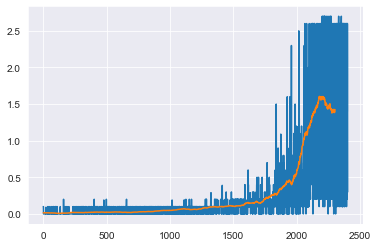

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

plt.plot(max_scores)
plt.plot(avg_scores)
plt.grid(True)
plt.show()

In [31]:
import pandas as pd
df = pd.DataFrame(max_scores)
df.to_csv('MADDPG_max_scores.csv', encoding='utf-8')